# Online Phase: Multiple Input Single Output (MISO) Gaussian Process Regression (GPR)
This notebook takes the measurements and maps them to the reduced coefficients of the POD using a MISO-GPR.

Let us create the mesh from the OpenFOAM nodes and cells

In [70]:
from pyforce.tools.write_read import ReadFromOF

path_snaps = '../../../Data/MSFR/'

of = ReadFromOF(path_snaps+'OVERSPEED/', mode='pyvista')
domain = of.create_mesh()

Hexahedron cells selected


Let us import the snapshots, variable names and time

In [71]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('Results/times.npz')['fom_times']

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, VectorElement("Lagrange", domain.ufl_cell(), 1)),
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train and test and predict.

In [72]:
from sklearn.model_selection import train_test_split

Nt = len(fom_times)

_indices = np.arange(0, Nt)
train_indices, test_indices = train_test_split(_indices, test_size=0.2, random_state=42)

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)

train_snaps = dict()
test_snaps = dict()

for field_i, field in enumerate(var_names):
    # Train snaps
    train_snaps[field] = FunctionsList(fun_spaces[field_i])
    for ii in train_indices:
        train_snaps[field].append(snaps[field](ii) / snaps[field](0).max())

    # Test snaps
    test_snaps[field] = FunctionsList(fun_spaces[field_i])
    for ii in test_indices:
        test_snaps[field].append(snaps[field](ii) / snaps[field](0).max())

Let us load the reduced coefficients, the singular values and the POD modes

In [82]:
path_pod_offline = 'Results/POD_offline/'

sing_vals = dict()
Vh_train  = dict()
pod_modes = dict()

for field_i, field in enumerate(var_names):

    sing_vals[field] = np.load(f'{path_pod_offline}POD_{field}_sing_vals.npz', allow_pickle=True)['sing_vals']
    Vh_train[field]  = np.load(f'{path_pod_offline}POD_{field}_Vh_train.npz', allow_pickle=True)['Vh_train']

    tmp_pod_modes = np.load(f'{path_pod_offline}POD_{field}_modes.npz', allow_pickle=True)['modes']
    pod_modes[field] = FunctionsList(fun_spaces[field_i])
    for ii in range(tmp_pod_modes.shape[1]):
        pod_modes[field].append(tmp_pod_modes[:, ii])

Let us load the magic sensors to extract the measurements

In [75]:
from pyforce.tools.write_read import ImportH5

path_geim_offline = 'Results/GEIM_offline/'

measured_field_i = 0
strategy = 'Out'

magic_sensors = ImportH5(fun_spaces[measured_field_i],
                          path_geim_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_ms',
                          f'GEIM_{var_names[measured_field_i]}_{strategy}_ms')[0]

from pyforce.tools.backends import norms, LoopProgress
_norm = norms(fun_spaces[measured_field_i])

noise_value = 5e-4

train_measurements = np.zeros((len(train_snaps[var_names[measured_field_i]]), len(magic_sensors)))

bar = LoopProgress(final=len(train_snaps[var_names[measured_field_i]]), msg='Computing train measurements')
for ii, snap in enumerate(train_snaps[var_names[measured_field_i]]._list):
    for mm in range(len(magic_sensors)):
        train_measurements[ii, mm] = _norm.L2innerProd(snap, magic_sensors(mm)) + noise_value * np.random.randn()
    bar.update(1)

bar = LoopProgress(final=len(train_snaps[var_names[measured_field_i]]), msg='Computing train measurements')
test_measurements = np.zeros((len(test_snaps[var_names[measured_field_i]]), len(magic_sensors)))
for ii, snap in enumerate(test_snaps[var_names[measured_field_i]]._list):
    for mm in range(len(magic_sensors)):
        test_measurements[ii, mm] = _norm.L2innerProd(snap, magic_sensors(mm)) + noise_value * np.random.randn()
    bar.update(1)

Computing train measurements: 400.000 / 400.00 - 0.151 s/it


Let us plot the measurements with noise

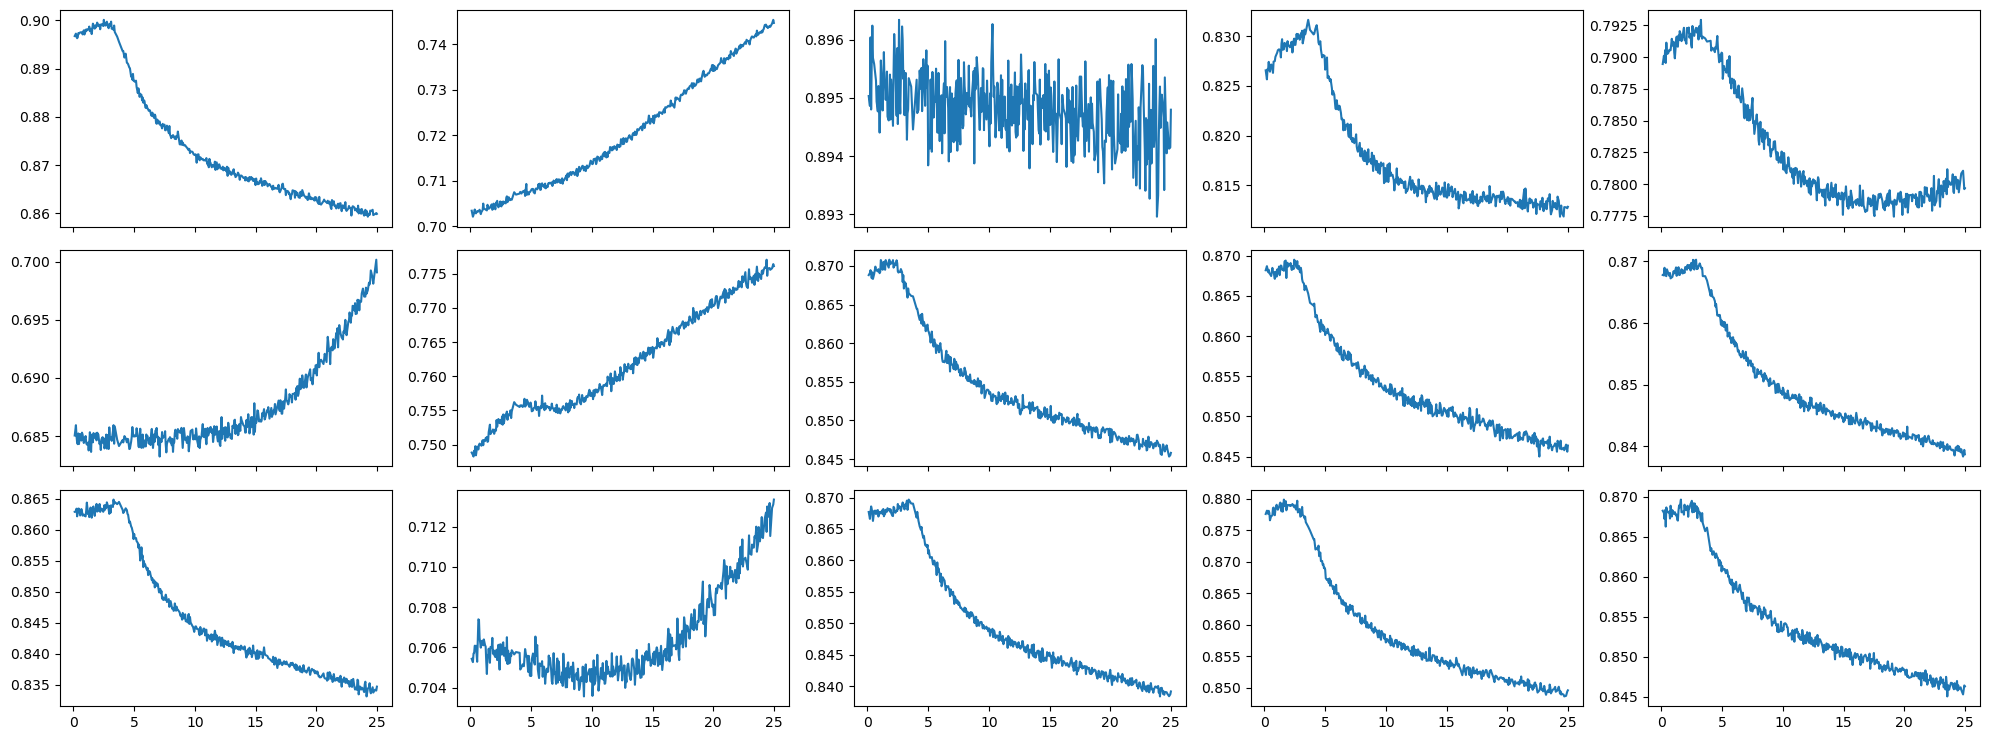

In [76]:
nrows = 3
ncols = 5
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 2.5 * nrows), sharex=True)
axs = axs.flatten()

for mm in range(train_measurements.shape[1]):
    axs[mm].plot(fom_times[train_indices], train_measurements[:, mm], label='Train measurements')

plt.tight_layout()

# Train the MISO-GPR model
This section trains the MISO-GPR model using the measurements and the reduced coefficients.


In [77]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scale the measurements
measure_scaler = MinMaxScaler()
measure_scaler.fit(train_measurements)

# Scale the reduced coefficients
pod_scaler = dict()
for field in var_names:
    pod_scaler[field] = StandardScaler()
    pod_scaler[field].fit(Vh_train[field].T)

# Define the kernel for the Gaussian Process
kernels = dict()
for field in var_names:
    kernels[field] = dict()
    for rr in range(Vh_train[field].shape[1]):
        kernels[field][rr] = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-6, 1e2)) + WhiteKernel(
                                noise_level=1, noise_level_bounds=(1e-6, 1e2)
                            )

_gpr_train_indices, _gpr_valid_indices = train_test_split(np.arange(len(train_measurements)), test_size=0.2, random_state=42)

# Train the GPR models
gpr_models = dict()
for field in var_names:
    
    gpr_models[field] = dict()
    
    # Scaled messurements
    scaled_measurements = measure_scaler.transform(train_measurements[_gpr_train_indices])
        
    # Scaled reduced coefficients
    scaled_reduced_coeffs = pod_scaler[field].transform(Vh_train[field][:, _gpr_train_indices].T)
    
    for rr in range(Vh_train[field].shape[0]):

        print(f'Training GPR model for field: {field}, mode: {rr+1}/{Vh_train[field].shape[0]}', end='\r')

        gpr_models[field][rr] = GaussianProcessRegressor(kernel=kernels[field][rr], n_restarts_optimizer=10, alpha=1e-8)
        gpr_models[field][rr].fit(scaled_measurements, scaled_reduced_coeffs[:, rr].reshape(-1, 1))
    
    print(f'Training GPR model for field: {field} - Done!')

Training GPR model for field: T - Done!15/15
Training GPR model for field: flux1 - Done!15/15


Training GPR model for field: U - Done!15/15


Let us assess the model performance

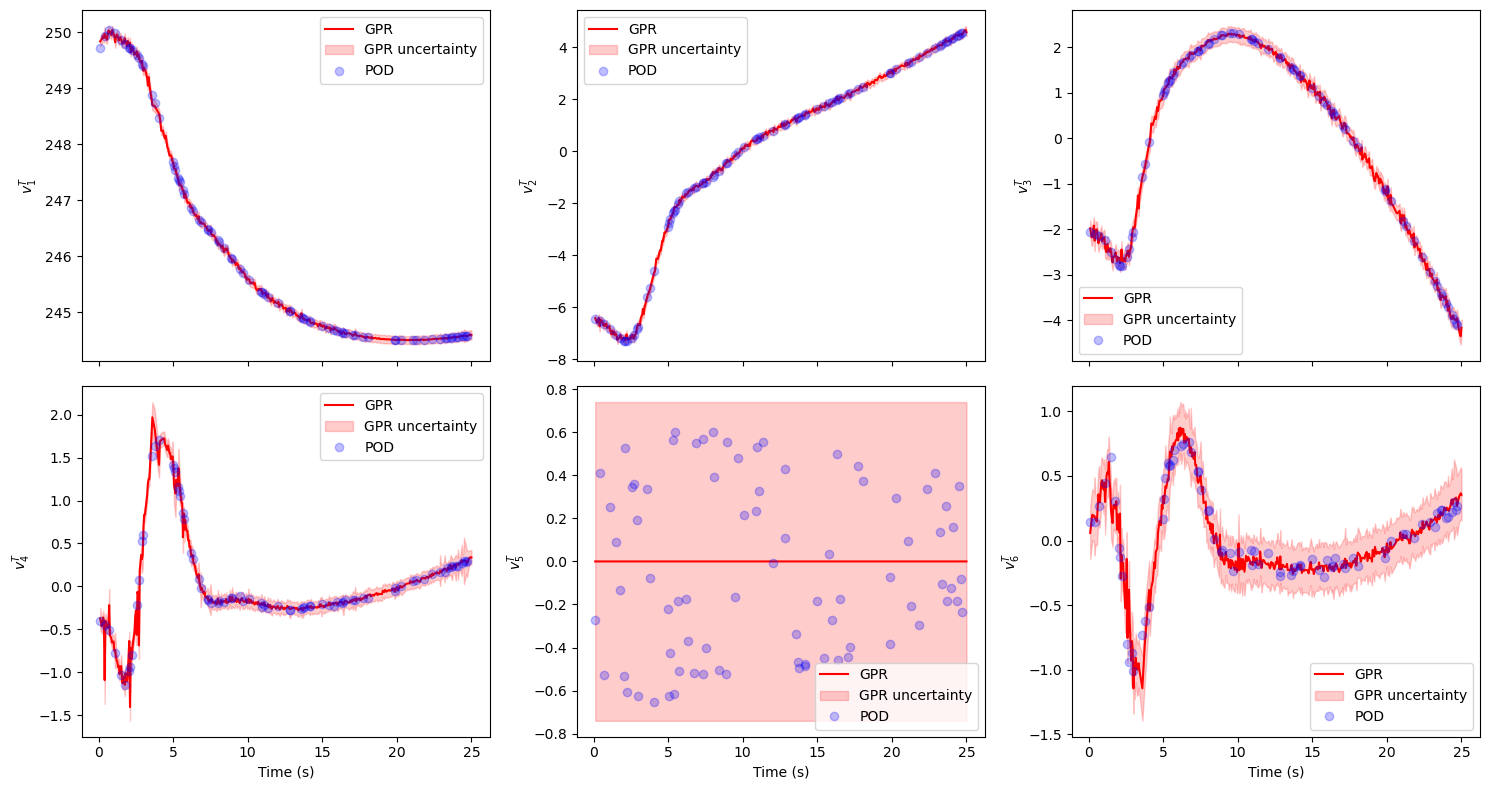

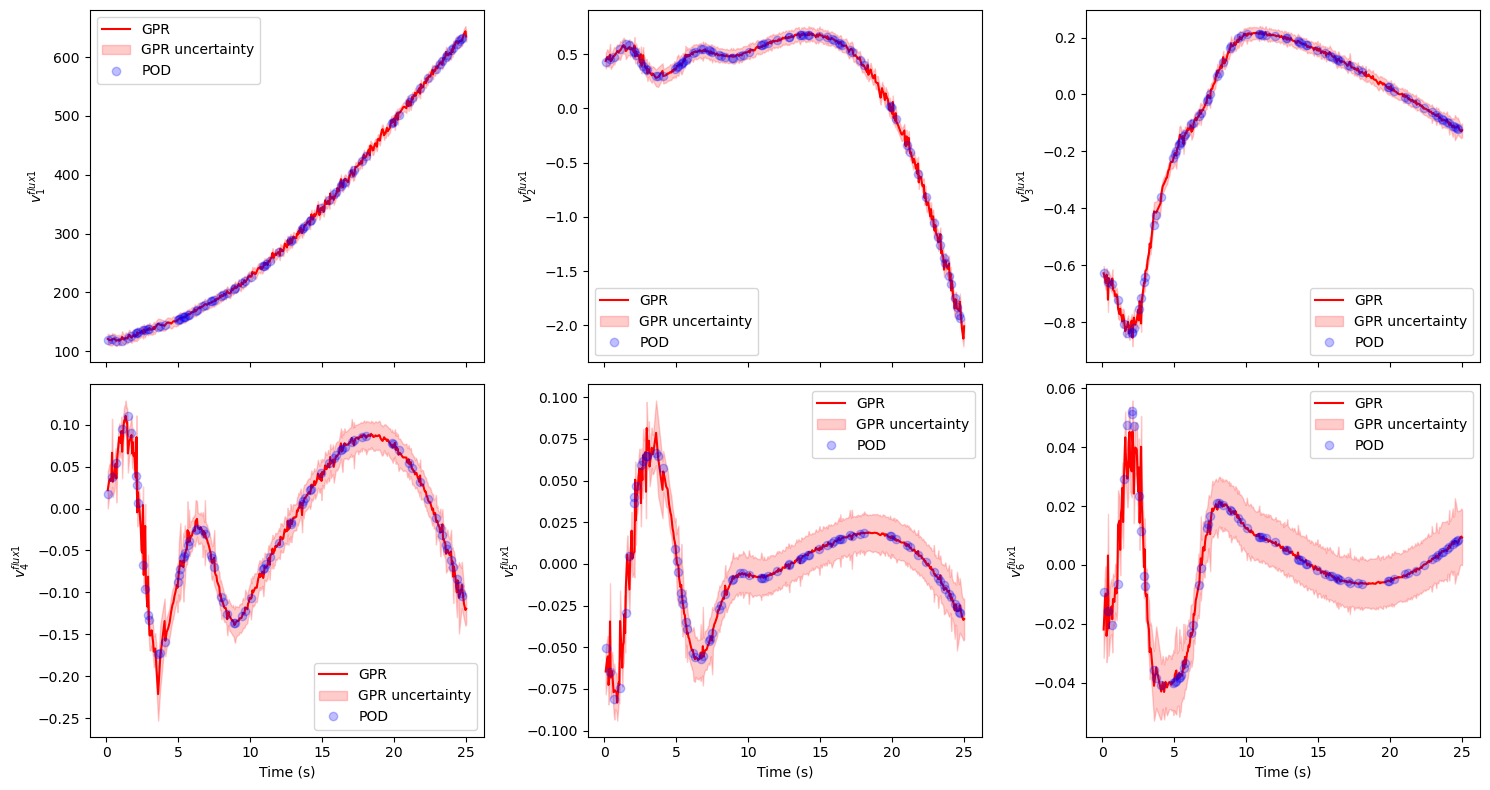

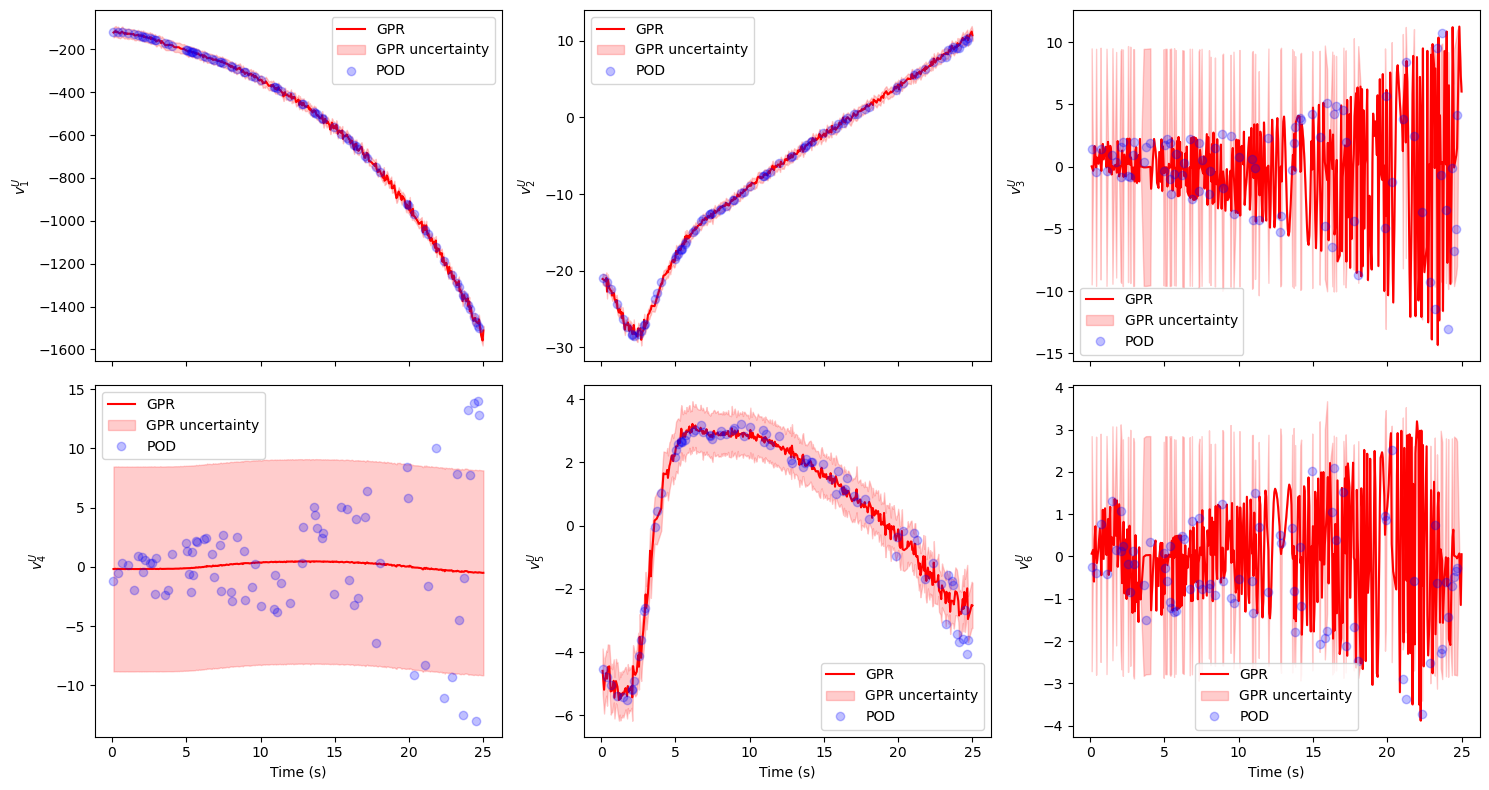

In [ ]:
ranks_to_plot = np.arange(6)

ncols = 3
nrows = 2

# Rescale the measurements
scaled_measurements = measure_scaler.transform(train_measurements)

for field in var_names:
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True)
    axs = axs.flatten()

    for kk, rr in enumerate(ranks_to_plot):


        # Rescale the reduced coefficients
        _reduced_coeffs = Vh_train[field].T[np.sort(_gpr_valid_indices)]

        # Predict the reduced coefficients
        reduced_coeffs_pred, std_gpr = gpr_models[field][rr].predict(scaled_measurements, return_std=True)
        reduced_coeffs_pred = reduced_coeffs_pred * pod_scaler[field].scale_[rr] + pod_scaler[field].mean_[rr]
        std_gpr = std_gpr * pod_scaler[field].scale_[rr]
        
        axs[kk].plot(fom_times[train_indices], reduced_coeffs_pred, label=f'GPR', color='r')
        axs[kk].fill_between(fom_times[train_indices],
                            reduced_coeffs_pred - 2 * std_gpr,
                            reduced_coeffs_pred + 2 * std_gpr,
                            alpha=0.2, color='r', label='GPR uncertainty')
        axs[kk].plot(fom_times[train_indices[np.sort(_gpr_valid_indices)]], 
                    _reduced_coeffs[:, rr], 'o', label=f'POD', color='b', alpha=0.25)
        axs[kk].set_ylabel(r'$v^{' + field + r'}_{' + str(rr+1) + r'}$')

        if kk >= ncols:
            axs[kk].set_xlabel('Time (s)')
        axs[kk].legend()

    plt.tight_layout()

## POD with Interpolation using MISO-GPR
The coefficients estimated with MISO-GPR are used to reconstruct the snapshots.

In [83]:
from pyforce.online.pod_interpolation import PODI

podi_online = dict()
for field in var_names:
    podi_online[field] = PODI(pod_modes[field], maps=None, name=field)

ld: warning: duplicate -rpath '/Users/sriva/miniconda3/envs/ml/lib' ignored


Let us compute the test error

In [89]:
ave_abs_error = dict()
ave_rel_error = dict()
compt_time    = dict()

for field in var_names:

    print(f'Computing PODI online for field: {field}')

    scaled_measurements = measure_scaler.transform(test_measurements)

    reduced_coeffs_pred = np.asarray([gpr_models[field][rr].predict(scaled_measurements, return_std=False)
                                    for rr in range(len(pod_modes[field]))]).T
    reduced_coeffs_pred = pod_scaler[field].inverse_transform(reduced_coeffs_pred)
    res = podi_online[field].synt_test_error(   test_snaps[field],
                                                mu_estimated=None, 
                                                maxBasis=len(pod_modes[field]),
                                                alpha_coeffs=reduced_coeffs_pred,
                                                verbose=True
                                                )
    
    ave_abs_error[field] = res[0]
    ave_rel_error[field] = res[1]
    compt_time[field] = res[2]

Computing PODI online for field: T
Computing POD test error (interpolation) - T: 100.000 / 100.00 - 0.167 s/it
Computing PODI online for field: flux1
Computing POD test error (interpolation) - flux1: 100.000 / 100.00 - 0.203 s/it
Computing PODI online for field: U
Computing POD test error (interpolation) - U: 100.000 / 100.00 - 0.386 s/it


Let us plot the errors

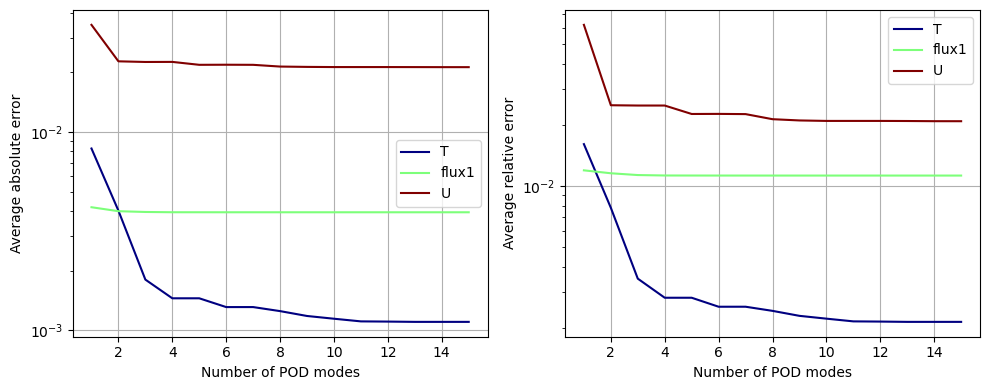

In [95]:
from matplotlib import cm

fig, axs = plt.subplots(1, 2, figsize=(10, 4))


colors = cm.jet(np.linspace(0, 1, len(var_names)))

for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, len(pod_modes[field]) + 1)
    axs[0].semilogy(N_plot, ave_abs_error[field], label=field, color=colors[field_i])
    axs[1].semilogy(N_plot, ave_rel_error[field], label=field, color=colors[field_i])

for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlabel('Number of POD modes')

axs[0].set_ylabel('Average absolute error')
axs[1].set_ylabel('Average relative error')

plt.tight_layout()

Let us make some contour plots

In [ ]:

    def reconstruct(self, snap: np.ndarray, mu_estimated: np.ndarray, maxBasis: int, 
                          alpha_coeffs : np.ndarray = None):

In [137]:
recons = dict()
for field_i, field in enumerate(var_names):

    reduced_coeffs_pred = np.asarray([gpr_models[field][rr].predict(scaled_measurements, return_std=False)
                                    for rr in range(len(pod_modes[field]))]).T
    reduced_coeffs_pred = pod_scaler[field].inverse_transform(reduced_coeffs_pred)

    recons[field] = FunctionsList(fun_spaces[field_i])
    
    for ii in range(len(test_snaps[field])):
        recons[field].append(podi_online[field].reconstruct(test_snaps[field](ii), mu_estimated=None, 
                                                            maxBasis=len(pod_modes[field]),
                                                            alpha_coeffs=reduced_coeffs_pred[ii, :])[0])

Let us make some plots

In [141]:
import importlib
import utils
importlib.reload(utils)


<module 'utils' from '/Users/sriva/Github/phd-thesis/support-code/Notebooks/Chapter4/ReflectorSensing/utils.py'>

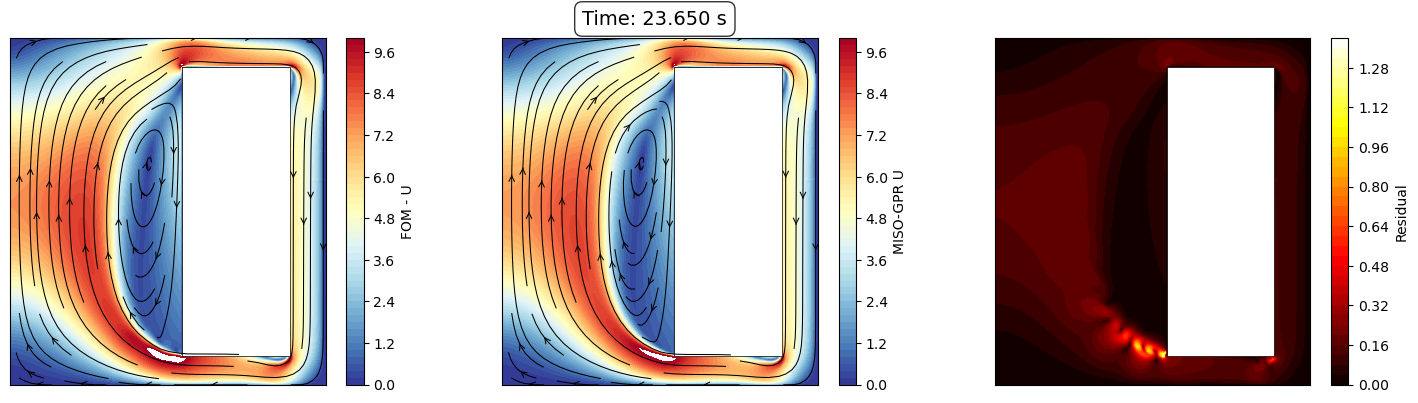

In [145]:
from utils import plot_contour
from IPython.display import clear_output as clc

mesh_to_plot = np.stack([domain.geometry.x[:, 0], domain.geometry.x[:, 2]], axis=1)
cmaps = [cm.jet, cm.viridis, cm.RdYlBu_r]

field_i = 2
field = var_names[field_i] 

levels = np.linspace(0, 10, 51) if field=='U' else np.linspace(test_snaps[field].return_matrix().min(), 
                                                                test_snaps[field].return_matrix().max(), 50)
streamline_plot = True if is_vector[field_i] else False
vec_mode_to_plot = True if is_vector[field_i] else None

# sampling = 10
# for tt in range(sampling-1, len(test_indices), sampling):
for tt in [90]:
    fig, axs = plt.subplots(1, 3, figsize=(6 * 3, 4.5))

    cont = plot_contour(axs[0], mesh_to_plot, test_snaps[field](tt), cmap=cmaps[field_i], levels=levels, 
                        full_core=False, vec_mode_to_plot=vec_mode_to_plot, streamline_plot=streamline_plot)
    plot_contour(axs[1], mesh_to_plot, recons[field](tt), cmap=cmaps[field_i], levels=levels, 
                        full_core=False, vec_mode_to_plot=vec_mode_to_plot, streamline_plot=streamline_plot)

    resid = np.abs(test_snaps[field](tt) - recons[field](tt))
    resid_cont = plot_contour(axs[2], mesh_to_plot, resid, cmap=cm.hot, levels=40, full_core=False, vec_mode_to_plot=vec_mode_to_plot)

    fig.colorbar(cont, ax=axs[0], label=f'FOM - {field}', orientation='vertical')
    fig.colorbar(cont, ax=axs[1], label=f'MISO-GPR {field}', orientation='vertical')

    fig.colorbar(resid_cont, ax=axs[2], label='Residual', orientation='vertical')

    # Add a box with the time information
    fig.text(
        0.45, 0.91, f"Time: {fom_times[test_indices[tt]]:.3f} s",
        fontsize=14,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8)
    )

    plt.show()
    clc(wait=True)
    plt.close(fig)